In [30]:
# Import necessary libraries


import torch

import numpy as np

import pandas as pd


import torch.nn as nn

import torch.optim as optim

from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



import seaborn as sns

from glob import glob

from pathlib import Path

import matplotlib.pyplot as plt

import plotly.graph_objects as go

import matplotlib.patches as mpatches

from matplotlib import colormaps, colors

from nilearn import datasets, maskers, plotting

from nilearn.maskers import NiftiLabelsMasker

from nilearn.connectome import ConnectivityMeasure





# Ignore warnings for cleaner output

import warnings

warnings.filterwarnings('ignore')



In [2]:
pip install --quiet torch==2.4.0 torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --quiet optuna-integration

Note: you may need to restart the kernel to use updated packages.


In [7]:


# Load demographic data

csv_path = '/kaggle/input/pixar/pixar_pheno.csv'

pheno = pd.read_csv(csv_path)



# Load fMRI feature data

feat_file = '/kaggle/input/pixar/pixar_features.npz'

X_features = np.load(feat_file)['a']



print('Demographic data shape:', pheno.shape)

print('Features shape:', X_features.shape)





# Device selection

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Demographic data shape: (155, 6)
Features shape: (155, 2016)


In [8]:
# Convert feature vectors to symmetric correlation matrices

def vector_to_symmetric_matrix(vector, size=64):

    full_matrix = np.zeros((size, size))

    full_matrix[np.triu_indices(size, k=1)] = vector

    return full_matrix + full_matrix.T



reshaped_features = np.array([vector_to_symmetric_matrix(f) for f in X_features])

In [9]:



# Standardize Age

scaler = StandardScaler()

age_data = torch.tensor(scaler.fit_transform(pheno[['Age']]), dtype=torch.float32).squeeze()  # Shape: (num_subjects,)



# Encode Gender

label_encoder = LabelEncoder()

gender_encoded = label_encoder.fit_transform(pheno['Gender'])  # Converts gender to numerical (e.g., 0 or 1)

gender_data = torch.tensor(gender_encoded, dtype=torch.long)  # Shape: (num_subjects,)


In [10]:
# Standardize ROI features

roi_features = torch.tensor(scaler.fit_transform(X_features), dtype=torch.float32)  # Shape: (num_subjects, num_features)


In [11]:
from torch.utils.data import TensorDataset, DataLoader, random_split



# Combine into TensorDataset

dataset = TensorDataset(roi_features, age_data, gender_data)  # (features, age, gender)



# Split dataset into train and test

train_size = int(0.8 * len(dataset))

test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size])



# Define DataLoader for batching

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [17]:
class EnhancedAgeROICorrelationModelWithGender(nn.Module):
    def __init__(self, roi_input_dim, embed_dim, num_heads, num_layers, dropout_rate, gender_embedding_dim):
        super(EnhancedAgeROICorrelationModelWithGender, self).__init__()

        # Gender Embedding
        self.gender_embedding = nn.Embedding(2, gender_embedding_dim)  # Assumes binary gender
        
        # Age MLP
        self.age_mlp = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # ROI Encoder
        self.roi_encoder = nn.Sequential(
            nn.Linear(roi_input_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_dim, embed_dim)
        )

        # Linear layer to project concatenated features back to embed_dim
        self.projection_layer = nn.Linear(embed_dim + embed_dim + gender_embedding_dim, embed_dim)

        # Transformer Encoder Layer
        self.positional_encoding = nn.Parameter(torch.zeros(1, embed_dim))  # Learnable positional encoding
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout_rate,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer, num_layers=num_layers
        )

        # Output layer for regression (age prediction)
        self.output_layer = nn.Linear(embed_dim, 1)

    def forward(self, roi_data, age, gender):
        # Process age through MLP
        age_embed = self.age_mlp(age.unsqueeze(-1))  # Shape: (batch_size, embed_dim)
        
        # Process gender through embedding
        gender_embed = self.gender_embedding(gender.long())  # Shape: (batch_size, gender_embedding_dim)

        # Process ROI data through the encoder
        roi_encoded = self.roi_encoder(roi_data)  # Shape: (batch_size, embed_dim)
        
        # Concatenate all inputs (age, gender, ROI)
        combined_input = torch.cat((roi_encoded, age_embed, gender_embed), dim=1)

        # Project concatenated features back to embed_dim
        combined_input = self.projection_layer(combined_input)  # Shape: (batch_size, embed_dim)
        
        # Add positional encoding and transformer processing
        combined_input = combined_input.unsqueeze(0)  # Add sequence dimension for transformer
        combined_input += self.positional_encoding

        transformer_output = self.transformer_encoder(combined_input)
        
        # Average pooling and final prediction
        combined_features = transformer_output.mean(dim=0)
        return self.output_layer(combined_features).squeeze(1)  # Output age prediction


In [18]:




# Hyperparameters and data

roi_input_dim = X_features.shape[1]

embed_dim = 128  # Example value, tuneable

num_heads = 4

num_layers = 2

dropout_rate = 0.1

gender_embedding_dim = 4  # Embedding size for gender input



model = EnhancedAgeROICorrelationModelWithGender(

    roi_input_dim=roi_input_dim,

    embed_dim=embed_dim,

    num_heads=num_heads,

    num_layers=num_layers,

    dropout_rate=dropout_rate,

    gender_embedding_dim=gender_embedding_dim

).to(device)



# Optimizer, Loss Function, Scheduler

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

loss_function = nn.MSELoss()



# Training Loop (Example)

num_epochs = 100

for epoch in range(num_epochs):

    model.train()

    epoch_loss = 0.0

    

    for roi_data, age, gender in train_loader:

        roi_data, age, gender = roi_data.to(device), age.to(device), gender.to(device)

        

        # Forward pass

        predictions = model(roi_data, age, gender)

        loss = loss_function(predictions, age)



        # Backward pass

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        

        epoch_loss += loss.item()



    # Validation and evaluation metrics

    model.eval()

    val_loss = 0.0

    all_predictions = []

    all_labels = []



    with torch.no_grad():

        for roi_data, age, gender in test_loader:

            roi_data, age, gender = roi_data.to(device), age.to(device), gender.to(device)

            

            predictions = model(roi_data, age, gender)

            val_loss += loss_function(predictions, age).item()



            all_predictions.extend(predictions.cpu().numpy())

            all_labels.extend(age.cpu().numpy())



    val_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")



    scheduler.step()






/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100, Train Loss: 0.5875, Val Loss: 0.2066
Epoch 2/100, Train Loss: 0.2078, Val Loss: 0.1712
Epoch 3/100, Train Loss: 0.2083, Val Loss: 0.0897
Epoch 4/100, Train Loss: 0.1272, Val Loss: 0.1130
Epoch 5/100, Train Loss: 0.0942, Val Loss: 0.0898
Epoch 6/100, Train Loss: 0.0807, Val Loss: 0.0759
Epoch 7/100, Train Loss: 0.0717, Val Loss: 0.0675
Epoch 8/100, Train Loss: 0.0641, Val Loss: 0.0617
Epoch 9/100, Train Loss: 0.0630, Val Loss: 0.0586
Epoch 10/100, Train Loss: 0.0685, Val Loss: 0.0580
Epoch 11/100, Train Loss: 0.0745, Val Loss: 0.0577
Epoch 12/100, Train Loss: 0.0649, Val Loss: 0.0569
Epoch 13/100, Train Loss: 0.0560, Val Loss: 0.0557
Epoch 14/100, Train Loss: 0.0579, Val Loss: 0.0535
Epoch 15/100, Train Loss: 0.0510, Val Loss: 0.0497
Epoch 16/100, Train Loss: 0.0462, Val Loss: 0.0468
Epoch 17/100, Train Loss: 0.0444, Val Loss: 0.0451
Epoch 18/100, Train Loss: 0.0370, Val Loss: 0.0432
Epoch 19/100, Train Loss: 0.0323, Val Loss: 0.0344
Epoch 20/100, Train Loss: 0.0306, Val Lo

In [19]:
# Final evaluation metrics

all_predictions = np.array(all_predictions)

all_labels = np.array(all_labels)

mse = mean_squared_error(all_labels, all_predictions)

mae = mean_absolute_error(all_labels, all_predictions)

r2 = r2_score(all_labels, all_predictions)



print(f"Final MSE: {mse:.4f}, MAE: {mae:.4f}, R^2 Score: {r2:.4f}")

Final MSE: 0.0198, MAE: 0.1017, R^2 Score: 0.9823


Final MSE: 0.0198, MAE: 0.1017, R^2 Score: 0.9823


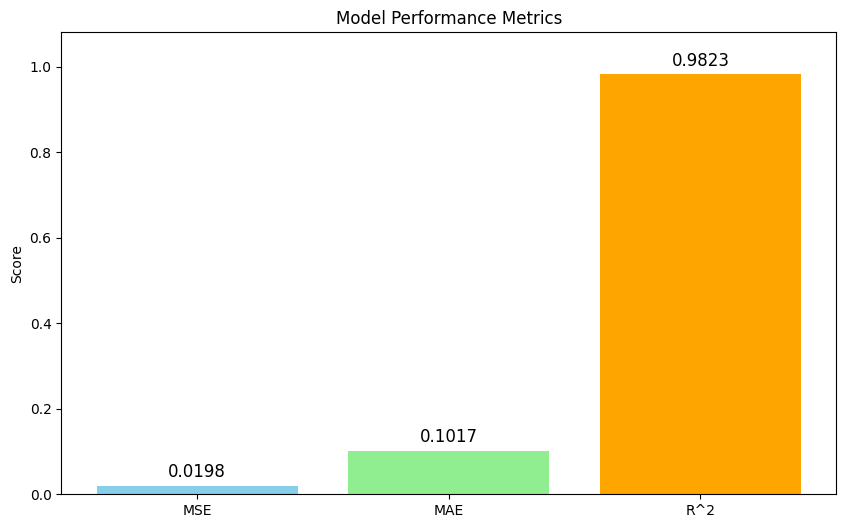

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Final predictions and labels
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate regression metrics
mse = mean_squared_error(all_labels, all_predictions)
mae = mean_absolute_error(all_labels, all_predictions)
r2 = r2_score(all_labels, all_predictions)

# Print metrics
print(f"Final MSE: {mse:.4f}, MAE: {mae:.4f}, R^2 Score: {r2:.4f}")

# Plot the metrics
metrics = {'MSE': mse, 'MAE': mae, 'R^2': r2}
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'orange'])
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, max(metric_values) * 1.1)  # Set Y-axis limit for visibility

for i, v in enumerate(metric_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)

plt.show()


In [26]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wrapping the model to ensure it works with perturbations
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, roi_data, age, gender):
        output = self.model(roi_data, age, gender)
        return output.unsqueeze(1)  # Ensures output shape is (batch_size, 1)

# Wrap your model
wrapped_model = ModelWrapper(model)
wrapped_model.eval()  # Set the model to evaluation mode


ModelWrapper(
  (model): EnhancedAgeROICorrelationModelWithGender(
    (gender_embedding): Embedding(2, 4)
    (age_mlp): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (roi_encoder): Sequential(
      (0): Linear(in_features=2016, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (projection_layer): Linear(in_features=260, out_features=128, bias=True)
    (transformer_encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features

In [31]:
def create_perturbation_bank(model, data_loader, epsilon=0.1, device="cuda"):
    perturbation_effects = []

    model.eval()  # Set model to evaluation mode

    # Iterate over each feature index in the ROI features
    for feature_idx in range(roi_input_dim):  # roi_input_dim is the number of features in ROI data
        effects = []

        # Process each batch from the data_loader
        for roi_data, age, gender in data_loader:
            roi_data, age, gender = roi_data.to(device), age.to(device), gender.to(device)
            
            # Forward pass with the original data
            outputs = model(roi_data, age, gender)

            # Perturb the feature in the input data
            perturbed_data = roi_data.clone()
            perturbed_data[:, feature_idx] += epsilon  # Perturb the feature by epsilon

            # Forward pass with the perturbed data
            perturbed_outputs = model(perturbed_data, age, gender)

            # Calculate the absolute effect of the perturbation
            effect = (outputs - perturbed_outputs).abs().mean().item()
            effects.append(effect)

        # Compute the average effect of the perturbation across the dataset
        perturbation_effects.append((feature_idx, np.mean(effects)))

    # Sort features by sensitivity (effect size)
    perturbation_effects_sorted = sorted(perturbation_effects, key=lambda x: x[1], reverse=True)

    return perturbation_effects_sorted


In [32]:
dim = 64

difumo = datasets.fetch_atlas_difumo(

    dimension=dim, resolution_mm=2, legacy_format=False

)



atlas_filename = difumo.maps


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/difumo_atlases



 ...done. (4 seconds, 0 min)
Extracting data from /root/nilearn_data/difumo_atlases/0fd53859aa9fed124e741c85ec45c705/download..... done.


 ...done. (2 seconds, 0 min)


In [55]:
import pandas as pd
import numpy as np
import torch

def generate_feature_importance(model, data_loader, labels, epsilon=0.1, device="cuda"):
    """
    Generate feature importance based on perturbation effects for a given model.

    Args:
        model: The trained model to be evaluated.
        data_loader: DataLoader containing test data.
        labels: List of feature names for generating feature pairs.
        epsilon: The amount of perturbation applied to each feature.
        device: Device on which the model is loaded (default is 'cuda').

    Returns:
        A DataFrame containing feature importance sorted by their effect.
    """
    # Prepare feature names (can be extended if pairwise features are needed)
    feature_names = labels
    num_features = len(feature_names)

    # Create DataFrame to map feature indices to names
    feature_mapping_df = pd.DataFrame({
        'Feature Index': range(1, num_features + 1),
        'Feature Name': feature_names
    })

    # Initialize list to store perturbation effects
    perturbation_effects = []

    # Set model to evaluation mode
    model.eval()

    # Iterate through each feature in the model
    for feature_idx in range(num_features):
        effects = []

        # Iterate through the data loader (batch by batch)
        for roi_data, age, gender in data_loader:
            roi_data, age, gender = roi_data.to(device), age.to(device), gender.to(device)

            # Forward pass with original data
            outputs = model(roi_data, age, gender)

            # Perturb the specific feature
            perturbed_data = roi_data.clone()
            perturbed_data[:, feature_idx] += epsilon  # Apply perturbation

            # Forward pass with the perturbed data
            perturbed_outputs = model(perturbed_data, age, gender)

            # Calculate the absolute effect of the perturbation
            effect = (outputs - perturbed_outputs).abs().mean().item()
            effects.append(effect)

        # Compute the average effect of the perturbation across the dataset
        perturbation_effects.append((feature_idx + 1, np.mean(effects)))

    # Convert perturbation effects to DataFrame
    perturbation_df = pd.DataFrame(perturbation_effects, columns=['Feature Index', 'Importance'])

    # Map the feature index to the corresponding feature name
    perturbation_df['Feature Name'] = perturbation_df['Feature Index'].apply(
        lambda x: feature_mapping_df.loc[feature_mapping_df['Feature Index'] == x, 'Feature Name'].values[0]
    )

    # Sort by importance and reset the index
    perturbation_df = perturbation_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return perturbation_df


# Example usage:
# Assuming `final_model`, `test_loader`, and `labels` are already defined:
perturbation_df = generate_feature_importance(model, test_loader, difumo.labels["difumo_names"])
# Display the feature importance
perturbation_df


,Feature Index,Importance,Feature Name
0,24,0.000316,Descending occipital gyrus
1,46,0.000314,Occipital pole
2,60,0.000275,Cuneus
3,43,0.000270,Callosomarginal sulcus
4,44,0.000269,Paracentral lobule superior
...,...,...,...
59,6,0.000130,Insula antero-superior
60,58,0.000128,Middle frontal gyrus anterior
61,57,0.000126,Superior parietal lobule
62,45,0.000113,Heschl’s gyrus


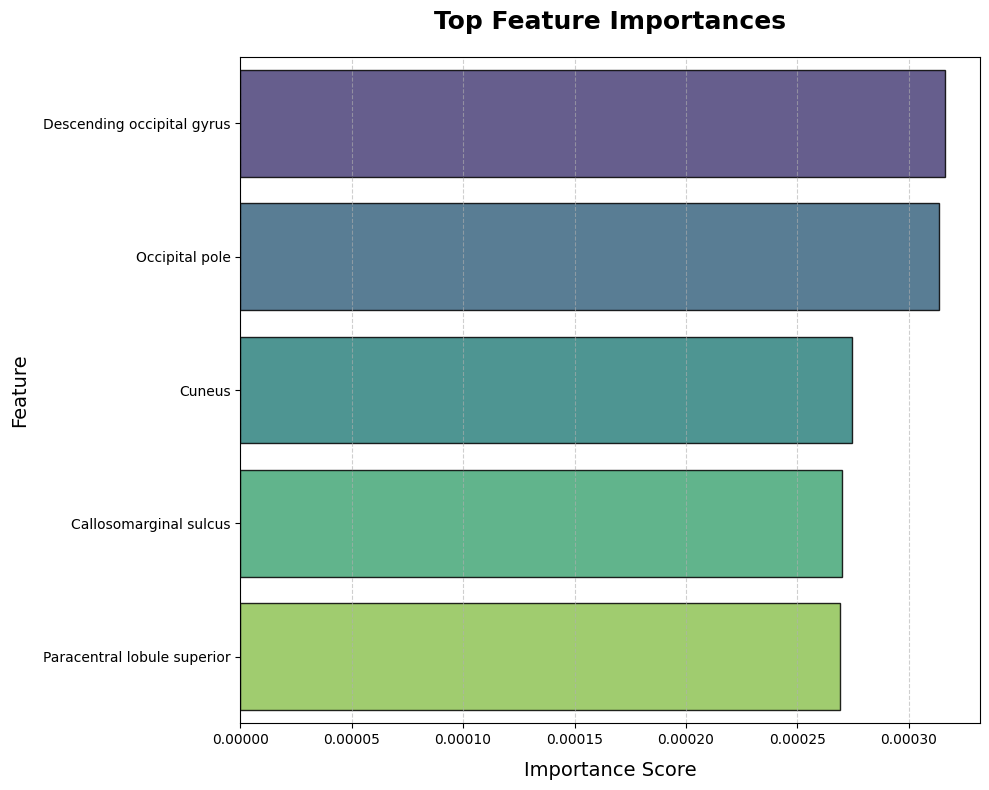

In [56]:
def plot_top_features(perturbation_df, top_n=5, title="Top Feature Importances"):
    """
    Plots the top N features based on their importance scores.

    Args:
        perturbation_df: DataFrame containing feature names and their calculated importance scores.
        top_n: The number of top features to plot.
        title: The title of the plot.

    Returns:
        None
    """
    # Get the top N features based on importance
    top_features = perturbation_df.head(top_n)

    # Plot the top features
    plt.figure(figsize=(10, 8))

    # Use a custom color palette
    custom_palette = sns.color_palette("viridis", len(top_features))

    # Create the barplot
    sns.barplot(x='Importance', y='Feature Name', data=top_features, palette=custom_palette, edgecolor='black', alpha=0.85)

    # Customize the title and labels
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Importance Score', fontsize=14, labelpad=10)
    plt.ylabel('Feature', fontsize=14, labelpad=10)

    # Add subtle gridlines
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Tweak the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming `perturbation_df` is already created from the generate_feature_importance function
plot_top_features(perturbation_df, top_n=5)